# Imports

In [1]:
import jax
import jax.numpy as jnp 
from jax import vmap, grad, jit
import optax
from sample_trajectory import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from jax.typing import ArrayLike

# Globals

In [2]:
horizon = 1000
batch_size = 1000
minibatch_size = 100
rep_dim = 16 
tau_fixation = 0.01
tau_saccade = 0.1
n_actions = 3 

# Sampling trajectories

In [3]:
# Generate Trajectories
init_key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(init_key, batch_size)
trajectories, goals = vmap(jit(lambda k: generate_trajectory(key=k, horizon=horizon)))(batch_keys)
angles, velocities, times = trajectories
angles.shape, velocities.shape, times.shape # batch_dim, horizon

((1000, 1000), (1000, 1000), (1000, 1000))

In [4]:
# Converting velocities into actions 
actions = (np.sign(velocities) - 3) / -2
actions[velocities == 0.0] = 0
actions = jnp.asarray(actions, dtype=int)

In [5]:
# Converting angles to one hot representations and adding an offset
one_hot_angles = jnp.pad(vmap(to_1_hot)(trajectories[0]), ((0,0), (0,0), (0,1)), mode='constant', constant_values=1.0) 
one_hot_goals = jnp.pad(vmap(to_1_hot)(goals), ((0,0), (0,1)), mode='constant', constant_values=1.0)
one_hot_angles.shape, one_hot_goals.shape

((1000, 1000, 97), (1000, 97))

In [6]:
# Sample like and dislike pairs 
n_samples = 50000
sample_keys = jax.random.split(batch_keys[-1], n_samples)
raw_state_triplets, index_triplets = vmap(
    sample_trajectory, in_axes=(0, None, None, None, None))(sample_keys, one_hot_angles, actions, tau_saccade, tau_fixation)
[(x.shape, y.shape) for x, y in zip(raw_state_triplets, index_triplets)]

[((50000, 97), (50000,)), ((50000, 97), (50000,)), ((50000, 97), (50000,))]

In [7]:
# Get actions for each anchor state
anchor_batch_idxs = index_triplets[0] // horizon
anchor_idxs = index_triplets[0] % horizon
anchor_actions = actions[anchor_batch_idxs, anchor_idxs]
# Initialize container variable - include new axis for different actions
extended_anchor_states = np.zeros((raw_state_triplets[0].shape[0], n_actions, raw_state_triplets[0].shape[1]))
# Populate with correct anchor state at selected action
extended_anchor_states[np.arange(n_samples), anchor_actions] = raw_state_triplets[0]
# Flatten over actions 
extended_anchor_states = jnp.reshape(extended_anchor_states, (n_samples, -1))
state_triplets = raw_state_triplets.copy()
state_triplets[0] = extended_anchor_states
[x.shape for x in state_triplets]


[(50000, 291), (50000, 97), (50000, 97)]

In [82]:
# Splitting data into train / val / test
train_ratio = 0.8
val_ratio = 0.1 
train_index = int(n_samples * train_ratio)
val_index = int(n_samples * val_ratio) + train_index

train_set = [x[:train_index] for x in state_triplets]
val_set = [x[train_index:val_index] for x in state_triplets]
test_set = [x[val_index:] for x in state_triplets]

# Collate data into minibatches
batched_train = [jnp.reshape(x, (x.shape[0] // minibatch_size, minibatch_size, -1)) for x in train_set]
[x.shape for x in batched_train]

[(400, 100, 291), (400, 100, 97), (400, 100, 97)]

# Optimization

In [84]:
var_keys = jax.random.split(sample_keys[-1], 2)

# (rep_dim, input_dim x n_actions)
phi = jax.random.normal(key=var_keys[0], shape=(rep_dim, train_set[0].shape[-1])) 
# (rep dim, input_dim)
psi = jax.random.normal(key=var_keys[1], shape=(rep_dim, train_set[1].shape[-1]))

# Column normalize  
phi_norms = jnp.linalg.norm(phi, axis=0, keepdims=True)
psi_norms = jnp.linalg.norm(psi, axis=0, keepdims=True)
phi /= phi_norms 
psi /= psi_norms 
print(jnp.linalg.norm(phi, axis=0).sum(), jnp.linalg.norm(psi, axis=0).sum())

params = {'phi': phi, 'psi': psi}

291.0 97.0


In [85]:
# Creating the optimizer 
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)
print(opt_state)

(ScaleByAdamState(count=Array(0, dtype=int32), mu={'phi': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'psi': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}, nu={'phi': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'psi': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0.,

In [86]:
# Training step 
@jit
def train_step(params: optax.Params, opt_state: Tuple , batch: List[ArrayLike]) -> Tuple[optax.Params, Tuple, float]:
    """_summary_

    Args:
        params (optax.Params): Parameters to optimize
        opt_state (Tuple): Current optimizer state 
        batch (List[ArrayLike]): (Anchor states, like_states, dislike_states)

    Returns:
        Tuple[optax.Params, Tuple, float]: new params, opt_state, loss over minibatch
    """
    loss, grads = jax.value_and_grad(contrastive_loss)(params, *batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss
    

In [87]:
n_epochs = 100
loss_history = []
val_loss_history = []
param_history = []
n_batches = batched_train[0].shape[0]
for epoch in range(n_epochs):
    for i in range(n_batches):
        minibatch = [x[i] for x in batched_train]
        params, opt_state, loss = train_step(params, opt_state, minibatch)
        if i % 100 == 0: print(f"Loss at epoch {epoch}, step {i}: {loss}")
    
    val_loss_history.append(contrastive_loss(params, *val_set))
    loss_history.append(loss)
    param_history.append(params)

Loss at epoch 0, step 0: 1.4598029851913452
Loss at epoch 0, step 100: 1.4530324935913086
Loss at epoch 0, step 200: 1.4237700700759888
Loss at epoch 0, step 300: 1.373659610748291
Loss at epoch 1, step 0: 1.394328236579895
Loss at epoch 1, step 100: 1.4196652173995972
Loss at epoch 1, step 200: 1.3991024494171143
Loss at epoch 1, step 300: 1.357250690460205
Loss at epoch 2, step 0: 1.3774833679199219
Loss at epoch 2, step 100: 1.403950810432434
Loss at epoch 2, step 200: 1.384226679801941
Loss at epoch 2, step 300: 1.3455222845077515
Loss at epoch 3, step 0: 1.3673732280731201
Loss at epoch 3, step 100: 1.3932894468307495
Loss at epoch 3, step 200: 1.3754785060882568
Loss at epoch 3, step 300: 1.3384095430374146
Loss at epoch 4, step 0: 1.3597705364227295
Loss at epoch 4, step 100: 1.3849239349365234
Loss at epoch 4, step 200: 1.3699793815612793
Loss at epoch 4, step 300: 1.3336251974105835
Loss at epoch 5, step 0: 1.352221965789795
Loss at epoch 5, step 100: 1.3777456283569336
Loss a

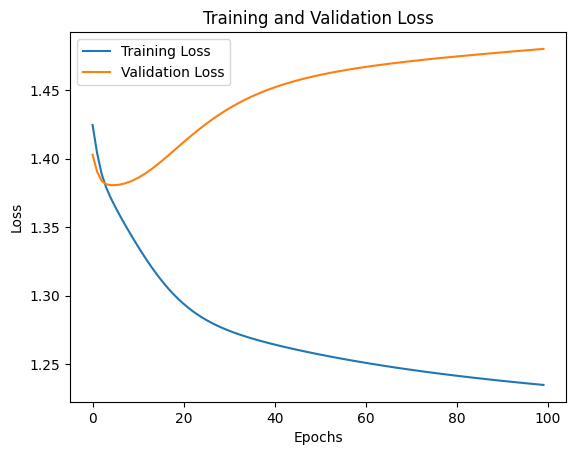

In [88]:
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend();